In [1]:
#Imports
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### 1. (40pts) Define functions

In [2]:

# One hot encode the labels
def one_hot_encode(y):
    enc = pd.get_dummies(y)
    return np.matrix(enc)


# Get the cost of iteration
def get_cost(y, y_pred):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y))
    return cost
    

#Get the accuracy of the results
def get_accuracy(y, y_pred):
    y = tf.nn.softmax(y)
    y_pred = tf.nn.softmax(y_pred)
    labels_equal = tf.equal(y, y_pred)
    accuracy = tf.reduce_mean(tf.cast(labels_equal, 'float'))
    return accuracy

# Initialize the hidden layer and output layer dimensions and apply activations on them
def initialize_deep_net(X, inputLayerSize, hiddenLayerSizes, outputLayerSize, keep_prob):
    
    # Xavier Weight Initialization
    hidden_layer_1 = {'W': tf.get_variable('W1', [inputLayerSize, hiddenLayerSizes[0]], initializer=tf.contrib.layers.xavier_initializer(seed = 1)),
                       'b': tf.get_variable('b1', [hiddenLayerSizes[0]],dtype=tf.float32, initializer=tf.zeros_initializer())}
    
    hidden_layer_2 = {'W':tf.get_variable('W2', [hiddenLayerSizes[0], hiddenLayerSizes[1]], initializer=tf.contrib.layers.xavier_initializer(seed = 1)),
                       'b':tf.get_variable('b2', [hiddenLayerSizes[1]],dtype=tf.float32, initializer=tf.zeros_initializer())}
    
    output_layer = {'W':tf.get_variable('W3', [hiddenLayerSizes[1], outputLayerSize], initializer=tf.contrib.layers.xavier_initializer(seed = 1)),
                       'b':tf.get_variable('b3', [outputLayerSize],dtype=tf.float32, initializer=tf.zeros_initializer())}
    
    return hidden_layer_1, hidden_layer_2, output_layer

def forward_propagation(X, inputLayerSize, hiddenLayerSizes, outputLayerSize, keep_prob):
    # Initialize the parameters
    hidden_layer_1, hidden_layer_2, output_layer = initialize_deep_net(X, inputLayerSize, 
                                                                hiddenLayerSizes, outputLayerSize, keep_prob)
    
    layer1 = tf.add(tf.matmul(tf.cast(X, tf.float32),hidden_layer_1['W']), hidden_layer_1['b'])
    layer1 = tf.nn.relu(layer1) # Relu on 1st Hidden Layer
    layer1_dropout = tf.nn.dropout(layer1, keep_prob, seed=2) # Drop-out Regularizarion
    
    
    layer2 = tf.add(tf.matmul(layer1_dropout,hidden_layer_2['W']), hidden_layer_2['b'])
    layer2 = tf.nn.relu(layer2) # Relu on 2nd Hidden Layer
    layer2_dropout = tf.nn.dropout(layer2, keep_prob, seed=2) # Drop-out Regularizarion

    output = tf.matmul(layer2_dropout,output_layer['W']) + output_layer['b']
    output = tf.nn.sigmoid(output) # Sigmoid on Output Layer
    return output

def plotCostHistory(cost_history):
     plt.plot(cost_history)
     plt.ylabel('Cost');
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations')
     plt.show()
        
def plot_accuracies_with_keep_prob(cache, label):
    accuracy = cache['accuracy']
    keep_prob = cache['keep_prob']
    plt.ylabel('Accuracy')
    plt.xlabel('Keep Probability')
    plt.title('Train and Test Accuracy Progression with increasing Keep Probablity')
    ax = plt.gca()
    ax.plot(keep_prob, accuracy, label=label)
    plt.legend()
    

### 2. Split data

In [3]:
# Reading the training data
data_train = pd.read_csv('ex4_train.csv', sep=",", encoding='utf-8', header='infer')
df_train = data_train.drop('Unnamed: 0',axis=1)

y_train = df_train['y']
X_train = df_train.drop(['y'], axis=1)

X_train_mat = np.matrix(X_train)

25    7
Name: y, dtype: int64


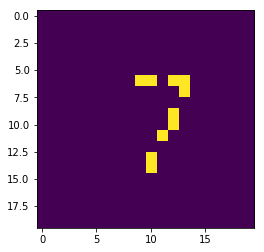

In [4]:
# Reading the test data
data_test = pd.read_csv('ex4_test.csv', sep=",", encoding='utf-8', header='infer')
df_test = data_test.drop('Unnamed: 0',axis=1)
m = df_test.shape[0]

y_test = df_test['y']
X_test = df_test.drop(['y'], axis=1)
X_test_mat = np.matrix(X_test)

# Plot the selected pixel
num = 25
pixels = np.array(X_test[num:num+1], dtype='uint8')
print(y_test[num:num+1])
pixels = pixels.reshape((20, 20)).T
plt.imshow(pixels)
plt.show()

### 3. Define number of neurons in each layer

In [5]:
inputLayerSize = X_train.shape[1]
hiddenLayers = 2
hiddenLayerSizes = [368,150]
outputLayerSize = 10

# One hot encode the labels
y_train_mat = one_hot_encode(y_train)
y_test_mat = one_hot_encode(y_test)

### 4. (30pts) Neural Network model with 2 hidden layers

In [6]:
def train_deep_neural_net(epochs, X_train, y_train, X_test, y_test, learning_rate, keep_prob):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, [None, X_train.shape[1]])
    y = tf.placeholder(tf.float32)
    y_pred = forward_propagation(x, inputLayerSize, hiddenLayerSizes, outputLayerSize, keep_prob)
    cost = get_cost(y, y_pred)
    # The AdamOptimizer is used in place of gradient descent to optimize the cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) 
    init = tf.global_variables_initializer()
    correctness = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1)) # Softmax Predictions
    accuracy = tf.reduce_mean(tf.cast(correctness, 'float'))
    cost_history = []
    max_test_acc = 0
    max_iter = 0
    train_acc = 0
    test_acc = 0
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs+1):
            temp, epoch_cost = sess.run([optimizer, cost], feed_dict={x:X_train, y:y_train})
            cost_history.append(epoch_cost)
            if(epoch % 1 == 0):
                train_acc = accuracy.eval({x:X_train, y:y_train})
                test_acc = accuracy.eval({x:X_test, y:y_test}) 
                if(test_acc > max_test_acc):
                    max_test_acc = test_acc
                    print('Max till now is ' , max_test_acc)
                    max_iter = epoch
                print('Accuracy Test: ' + str(test_acc) + ' on iteration ' + str(epoch))
                #print('Cost is ' + str(epoch_cost) + ' for iteration: ' + str(epoch))
        #plotCostHistory(cost_history)
        train_acc = train_acc * 100.0
        test_acc = test_acc * 100.0
        print('Train Accuracy: ', train_acc)
        print('Test Accuracy: ' ,test_acc)
        print('Max Test Accuracy: ' + str(max_test_acc* 100.0) + ' on iteration ' + str(max_iter))
        return train_acc, test_acc

### 5. (10pts) Predictions

In [7]:
def optimize(iterations, X_train_mat, y_train_mat, X_test_mat, y_test_mat, learning_rate):
    alphas = [0.01]
    trainCache = pd.DataFrame(columns=['accuracy','keep_prob'])
    testCache = pd.DataFrame(columns=['accuracy','keep_prob'])
    i=0
    for prob in [0.8]:
        for alpha in alphas:
            print('*************************************************************************************************')
            print('Keep probability: ' + str(prob))
            train_acc, test_acc = train_deep_neural_net(iterations, X_train_mat, y_train_mat, X_test_mat, y_test_mat, alpha, prob)
            print('test acc is : --- ' , test_acc)
            trainCache.loc[i] = pd.Series({'accuracy': train_acc, 'keep_prob': prob})
            testCache.loc[i] = pd.Series({'accuracy': test_acc, 'keep_prob': prob})
            i=i+1
    max_test_accuracy_index = testCache['accuracy'].idxmax()
    max_test_accuracy = testCache.iloc[[max_test_accuracy_index]]['accuracy'][max_test_accuracy_index]
    optimal_keep_prob = testCache.iloc[[max_test_accuracy_index]]['keep_prob'][max_test_accuracy_index]
    print('optimal keep probablity is ' + str(optimal_keep_prob))
    max_train_accuracy = trainCache.iloc[[max_test_accuracy_index]]['accuracy'][max_test_accuracy_index]
    print('*************************************************************************************************')
    print('Max Train Accuracy - ' + str(max_train_accuracy)) 
    print('Max Test Accuracy - ' + str(max_test_accuracy) )
    print('Optimal Keep Prob - ' + str(prob))
    print('Optimal Learning rate - ' + str(alpha))
    print('*************************************************************************************************')
    plot_accuracies_with_keep_prob(trainCache, 'Train')
    plot_accuracies_with_keep_prob(testCache, 'Test')
    plt.show()

### 6. (20pts) Optimization

*************************************************************************************************
Keep probability: 0.8
Max till now is  0.590667
Accuracy Test: 0.590667 on iteration 0
Max till now is  0.628
Accuracy Test: 0.628 on iteration 1
Accuracy Test: 0.568667 on iteration 2
Max till now is  0.713333
Accuracy Test: 0.713333 on iteration 3
Max till now is  0.718
Accuracy Test: 0.718 on iteration 4
Max till now is  0.742667
Accuracy Test: 0.742667 on iteration 5
Max till now is  0.787333
Accuracy Test: 0.787333 on iteration 6
Accuracy Test: 0.782 on iteration 7
Accuracy Test: 0.774667 on iteration 8
Max till now is  0.789333
Accuracy Test: 0.789333 on iteration 9
Max till now is  0.825333
Accuracy Test: 0.825333 on iteration 10
Max till now is  0.848667
Accuracy Test: 0.848667 on iteration 11
Max till now is  0.86
Accuracy Test: 0.86 on iteration 12
Max till now is  0.862667
Accuracy Test: 0.862667 on iteration 13
Max till now is  0.873333
Accuracy Test: 0.873333 on iteration 14
M

Accuracy Test: 0.944667 on iteration 183
Accuracy Test: 0.944667 on iteration 184
Accuracy Test: 0.943333 on iteration 185
Accuracy Test: 0.94 on iteration 186
Accuracy Test: 0.942 on iteration 187
Accuracy Test: 0.944 on iteration 188
Accuracy Test: 0.944667 on iteration 189
Accuracy Test: 0.943333 on iteration 190
Accuracy Test: 0.95 on iteration 191
Accuracy Test: 0.952667 on iteration 192
Accuracy Test: 0.938 on iteration 193
Accuracy Test: 0.941333 on iteration 194
Accuracy Test: 0.946 on iteration 195
Accuracy Test: 0.943333 on iteration 196
Accuracy Test: 0.946667 on iteration 197
Accuracy Test: 0.947333 on iteration 198
Accuracy Test: 0.947333 on iteration 199
Accuracy Test: 0.947333 on iteration 200
Accuracy Test: 0.948 on iteration 201
Accuracy Test: 0.944667 on iteration 202
Accuracy Test: 0.939333 on iteration 203
Accuracy Test: 0.942 on iteration 204
Accuracy Test: 0.942667 on iteration 205
Accuracy Test: 0.946667 on iteration 206
Accuracy Test: 0.944667 on iteration 207
A

Accuracy Test: 0.947333 on iteration 388
Accuracy Test: 0.950667 on iteration 389
Accuracy Test: 0.946667 on iteration 390
Accuracy Test: 0.944 on iteration 391
Accuracy Test: 0.946667 on iteration 392
Accuracy Test: 0.951333 on iteration 393
Accuracy Test: 0.943333 on iteration 394
Accuracy Test: 0.946667 on iteration 395
Accuracy Test: 0.95 on iteration 396
Accuracy Test: 0.941333 on iteration 397
Accuracy Test: 0.953333 on iteration 398
Accuracy Test: 0.950667 on iteration 399
Accuracy Test: 0.946 on iteration 400
Accuracy Test: 0.947333 on iteration 401
Accuracy Test: 0.946667 on iteration 402
Accuracy Test: 0.944667 on iteration 403
Accuracy Test: 0.947333 on iteration 404
Accuracy Test: 0.950667 on iteration 405
Accuracy Test: 0.942 on iteration 406
Accuracy Test: 0.945333 on iteration 407
Accuracy Test: 0.946667 on iteration 408
Accuracy Test: 0.943333 on iteration 409
Accuracy Test: 0.946 on iteration 410
Accuracy Test: 0.944 on iteration 411
Accuracy Test: 0.942667 on iteratio

Accuracy Test: 0.944667 on iteration 594
Accuracy Test: 0.940667 on iteration 595
Accuracy Test: 0.944 on iteration 596
Accuracy Test: 0.940667 on iteration 597
Accuracy Test: 0.946 on iteration 598
Accuracy Test: 0.938667 on iteration 599
Accuracy Test: 0.938667 on iteration 600
Accuracy Test: 0.942667 on iteration 601
Accuracy Test: 0.944667 on iteration 602
Accuracy Test: 0.935333 on iteration 603
Accuracy Test: 0.937333 on iteration 604
Accuracy Test: 0.944667 on iteration 605
Accuracy Test: 0.939333 on iteration 606
Accuracy Test: 0.944667 on iteration 607
Accuracy Test: 0.939333 on iteration 608
Accuracy Test: 0.943333 on iteration 609
Accuracy Test: 0.939333 on iteration 610
Accuracy Test: 0.944667 on iteration 611
Accuracy Test: 0.940667 on iteration 612
Accuracy Test: 0.941333 on iteration 613
Accuracy Test: 0.949333 on iteration 614
Accuracy Test: 0.943333 on iteration 615
Accuracy Test: 0.948 on iteration 616
Accuracy Test: 0.948 on iteration 617
Accuracy Test: 0.949333 on i

Accuracy Test: 0.948 on iteration 799
Accuracy Test: 0.944 on iteration 800
Accuracy Test: 0.942667 on iteration 801
Accuracy Test: 0.949333 on iteration 802
Accuracy Test: 0.948667 on iteration 803
Accuracy Test: 0.944 on iteration 804
Accuracy Test: 0.944 on iteration 805
Accuracy Test: 0.946667 on iteration 806
Accuracy Test: 0.944 on iteration 807
Accuracy Test: 0.946 on iteration 808
Accuracy Test: 0.94 on iteration 809
Accuracy Test: 0.942 on iteration 810
Accuracy Test: 0.944 on iteration 811
Accuracy Test: 0.941333 on iteration 812
Accuracy Test: 0.943333 on iteration 813
Accuracy Test: 0.946667 on iteration 814
Accuracy Test: 0.946 on iteration 815
Accuracy Test: 0.948 on iteration 816
Accuracy Test: 0.943333 on iteration 817
Accuracy Test: 0.942 on iteration 818
Accuracy Test: 0.944 on iteration 819
Accuracy Test: 0.946667 on iteration 820
Accuracy Test: 0.946667 on iteration 821
Accuracy Test: 0.945333 on iteration 822
Accuracy Test: 0.938 on iteration 823
Accuracy Test: 0.9

Accuracy Test: 0.942667 on iteration 1005
Accuracy Test: 0.942 on iteration 1006
Accuracy Test: 0.945333 on iteration 1007
Accuracy Test: 0.942667 on iteration 1008
Accuracy Test: 0.944 on iteration 1009
Accuracy Test: 0.939333 on iteration 1010
Accuracy Test: 0.948 on iteration 1011
Accuracy Test: 0.945333 on iteration 1012
Accuracy Test: 0.940667 on iteration 1013
Accuracy Test: 0.944667 on iteration 1014
Accuracy Test: 0.942 on iteration 1015
Accuracy Test: 0.944 on iteration 1016
Accuracy Test: 0.949333 on iteration 1017
Accuracy Test: 0.952 on iteration 1018
Accuracy Test: 0.944667 on iteration 1019
Accuracy Test: 0.940667 on iteration 1020
Accuracy Test: 0.948667 on iteration 1021
Accuracy Test: 0.944667 on iteration 1022
Accuracy Test: 0.944 on iteration 1023
Accuracy Test: 0.940667 on iteration 1024
Accuracy Test: 0.946 on iteration 1025
Accuracy Test: 0.952 on iteration 1026
Accuracy Test: 0.941333 on iteration 1027
Accuracy Test: 0.949333 on iteration 1028
Accuracy Test: 0.94

Accuracy Test: 0.946667 on iteration 1204
Accuracy Test: 0.945333 on iteration 1205
Accuracy Test: 0.944 on iteration 1206
Accuracy Test: 0.941333 on iteration 1207
Accuracy Test: 0.948 on iteration 1208
Accuracy Test: 0.948667 on iteration 1209
Accuracy Test: 0.948 on iteration 1210
Accuracy Test: 0.94 on iteration 1211
Accuracy Test: 0.948 on iteration 1212
Accuracy Test: 0.946667 on iteration 1213
Accuracy Test: 0.948 on iteration 1214
Accuracy Test: 0.945333 on iteration 1215
Accuracy Test: 0.944 on iteration 1216
Accuracy Test: 0.946667 on iteration 1217
Accuracy Test: 0.945333 on iteration 1218
Accuracy Test: 0.942667 on iteration 1219
Accuracy Test: 0.94 on iteration 1220
Accuracy Test: 0.944 on iteration 1221
Accuracy Test: 0.947333 on iteration 1222
Accuracy Test: 0.946 on iteration 1223
Accuracy Test: 0.945333 on iteration 1224
Accuracy Test: 0.946667 on iteration 1225
Accuracy Test: 0.944667 on iteration 1226
Accuracy Test: 0.942667 on iteration 1227
Accuracy Test: 0.948 on 

Accuracy Test: 0.954667 on iteration 1406
Accuracy Test: 0.950667 on iteration 1407
Accuracy Test: 0.946667 on iteration 1408
Accuracy Test: 0.95 on iteration 1409
Accuracy Test: 0.946 on iteration 1410
Accuracy Test: 0.954 on iteration 1411
Accuracy Test: 0.946667 on iteration 1412
Accuracy Test: 0.948 on iteration 1413
Accuracy Test: 0.946 on iteration 1414
Max till now is  0.956667
Accuracy Test: 0.956667 on iteration 1415
Train Accuracy:  99.6571421623
Test Accuracy:  95.6666648388
Max Test Accuracy: 95.6666648388 on iteration 1415
test acc is : ---  95.6666648388
optimal keep probablity is 0.8
*************************************************************************************************
Max Train Accuracy - 99.6571421623
Max Test Accuracy - 95.6666648388
Optimal Keep Prob - 0.8
Optimal Learning rate - 0.01
*************************************************************************************************


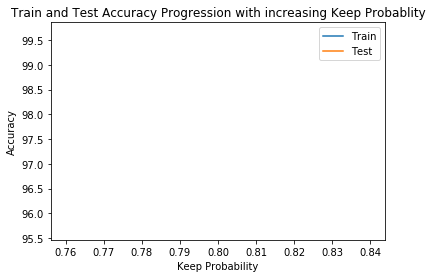

In [8]:
# Optimized Hyper Parameters
optimize(1415, X_train_mat, y_train_mat, X_test_mat, y_test_mat, 0.01)